In [26]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage,dendrogram

In [27]:
# AUTHOR: CONOR LANE, CONOR.LANE@MAIL.MCGILL.CA, Nov 2023

In [28]:
# IMPORTS AUDITORY EXAMPLE TWO-PHOTON DATA.  Add in your own filepath to the pickle file. 

example_auditory = 'C:/Users/Conor/Documents/Imaging_Data/example_auditory.pkl'

with open(example_auditory, 'rb') as f:
    example_auditory = pickle.load(f)

# Access a cell in the dictionary to examine its tuning.   # To examine data used in report, use 427, 77, 138, 1181
INPUT_DESIRED_CELL = 68

#  Input data structure is formatted as follows:

    # cell_n{ 
    #    'traces'{
    #           freq_f{
    #               intensity_i{
    #                     repetition{
    #                           [x,x,x,x,...] }}}}}



SECTION 1: Using SVD to calculate tuning properties of individual neurons.

In [29]:
# EXTRACT INFORMATION ABOUT STIMULUS PARADIGM



cell_ID = example_auditory[INPUT_DESIRED_CELL]
cell = cell_ID['traces']
nfreq = list(cell_ID['traces'].keys())  # Which sound frequencies were presented (Hz)?
nInt = list(cell_ID['traces'][nfreq[0]].keys()) # What intensities were presented (dB)?
ntrial = list(cell_ID['traces'][nfreq[0]][nInt[0]].keys()) # How many trials for each condition? 
print("Conditions:",nfreq, nInt, ntrial)

# In this case, there should be 12 frequencies at four intensities (48 conditions), with ten repeats of each. 
# Each condition contains a 15-frame vector of that cell's trial's relative fluorescence for that trial. 

matrix = np.array([[[cell[i][j][k] for k in ntrial] for j in nInt] for i in nfreq])
print("The shape of this matrix is:", matrix.shape)

# Average the matrix across the trials axis, so that we have one mean response for each frequency intensity combination. 
matrix_av = matrix.mean(axis=2)

# Reshape the matrix so that the baseline period mean is subtracted from the response period.  
normalized_matrix = matrix_av[:,:,5:].mean(axis=-1) - matrix_av[:,:,:5].mean(axis=-1)


Conditions: [4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922] [35, 50, 65, 80] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
The shape of this matrix is: (12, 4, 10, 15)


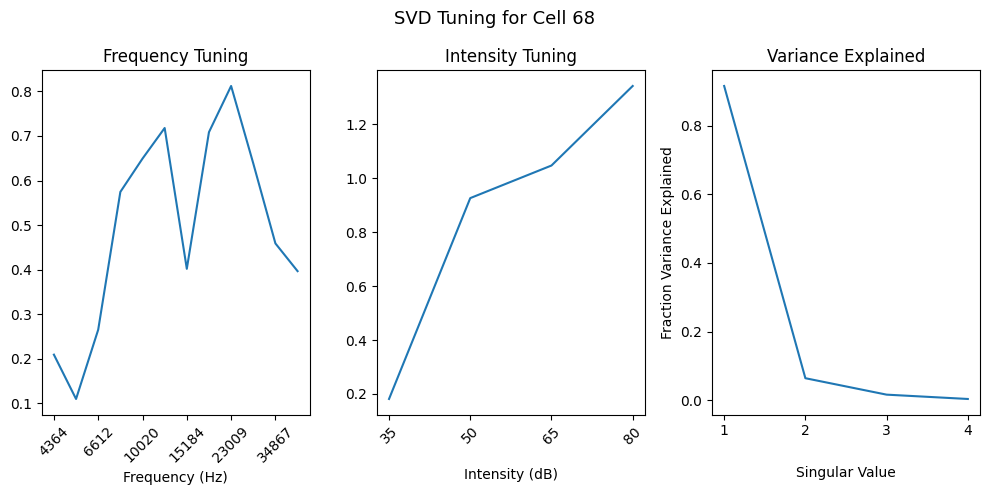

In [30]:
# PERFORMS SVD ON THE NORMALIZED MATRIX AND PLOTS LEFT (FREQUENCY) AND RIGHT (INTENSITY) SINGULAR VECTORS.
# IF THE FIRST SINGULAR VECTOR ACCOUNTS FOR MORE THAN 70% OF TOTAL VARIANCE, USES ONLY THIS, OTHERWISE USES
# THE SUM OF THE FIRST TWO SINGULAR VECTORS. 


# Perform SVD on the normalized matrix
U, S, Vt = np.linalg.svd(normalized_matrix)

fraction_variance = S**2/(S**2).sum()

U_var = np.abs(U[:,0]) if fraction_variance[0] > 0.95 else (np.abs(U[:,0]) + np.abs(U[:,1]))
Vt_var = np.abs(Vt[:,0]) if fraction_variance[0] > 0.95 else (np.abs(Vt[:,0]) + np.abs(Vt[:,1]))

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(10,5))

plt.suptitle('SVD Tuning for Cell ' + str(INPUT_DESIRED_CELL), fontsize=13)

ax[0].plot(U_var)
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_title("Frequency Tuning")
freq_positions = np.arange(len(nfreq))
ax[0].set_xticks(freq_positions[0::2])
ax[0].set_xticklabels(nfreq[0::2],rotation=45)

ax[1].plot(Vt_var)
ax[1].set_title("Intensity Tuning")
ax[1].set_xlabel("Intensity (dB)",labelpad=15)
ax[1].set_xticks(np.arange(len(nInt)))
ax[1].set_xticklabels(nInt,rotation=45)

ax[2].plot(S**2/(S**2).sum())
ax[2].set_xticks([0,1,2,3])
ax[2].set_xticklabels([1,2,3,4])
ax[2].set_title("Variance Explained")
ax[2].set_xlabel("Singular Value",labelpad=20)
ax[2].set_ylabel("Fraction Variance Explained")

plt.tight_layout()



([<matplotlib.axis.XTick at 0x2bb1cdde3a0>,
 [Text(0, 0, '4364'),
  Text(1, 0, '5371'),
  Text(2, 0, '6612'),
  Text(3, 0, '8140'),
  Text(4, 0, '10020'),
  Text(5, 0, '12335'),
  Text(6, 0, '15184'),
  Text(7, 0, '18691'),
  Text(8, 0, '23009'),
  Text(9, 0, '28324'),
  Text(10, 0, '34867'),
  Text(11, 0, '42922')])

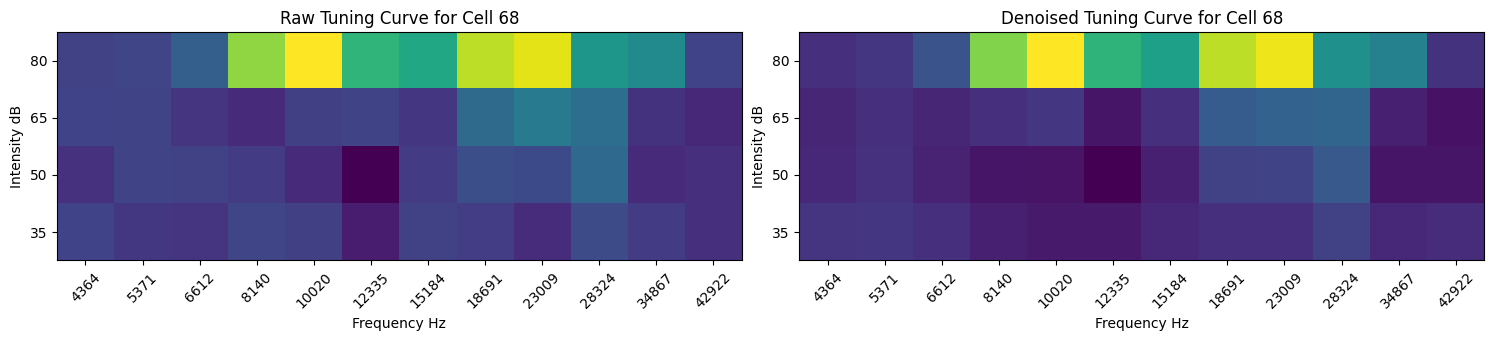

In [31]:

if fraction_variance[0] > 0.95:
    cell_denoised = (U[:,:1].reshape(-1,1) @ np.diag(S[:1]) @ Vt[:1].reshape(1,-1)).T
else:
    cell_denoised = (U[:,:2].reshape(-1,2) @ np.diag(S[:2]) @ Vt[:2].reshape(2,-1)).T

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})

# Plot the raw tuning curve
plt.subplot(1,2,1)
plt.tight_layout()
plt.imshow(normalized_matrix.T)
plt.gca().invert_yaxis()
plt.title("Raw Tuning Curve for Cell " + str(INPUT_DESIRED_CELL))
plt.xlabel("Frequency Hz")
plt.ylabel("Intensity dB")
plt.yticks(np.arange(len(nInt)))
plt.xticks(np.arange(len(nfreq)))
plt.xticks(rotation = 45)
plt.yticks(np.arange(len(nInt)),nInt)
plt.xticks(np.arange(len(nfreq)),nfreq,rotation=45)

# Plot the denoised tuning curve
plt.subplot(1,2,2)
plt.imshow(cell_denoised)
plt.gca().invert_yaxis()
plt.title("Denoised Tuning Curve for Cell " + str(INPUT_DESIRED_CELL))
plt.xlabel("Frequency Hz")
plt.ylabel("Intensity dB")
plt.yticks(np.arange(len(nInt)))
plt.xticks(np.arange(len(nfreq)))
plt.xticks(rotation = 45)
plt.yticks(np.arange(len(nInt)),nInt)
plt.xticks(np.arange(len(nfreq)),nfreq,rotation=45)

SECTION 2: USING SVD AND CLUSTERING ON TWO-PHOTON NEURONAL POPULATION DATA

In [32]:
# all cells and tuning curves 

matrix_frequency = []
matrix_intensity = []

for key in example_auditory.keys():
    cell_ID = example_auditory[key]
    cell0 = cell_ID['traces']
    nfreq = list(cell_ID['traces'].keys())
    nInt = list(cell_ID['traces'][nfreq[0]].keys())
    ntrial = list(cell_ID['traces'][nfreq[0]][nInt[0]].keys())

    matrix = np.array([[[cell0[i][j][k] for k in ntrial] for j in nInt] for i in nfreq])
        # Average the matrix across trials
    matrix_av = matrix.mean(axis=2)

    # Reshape the matrix so that the baseline mean is subtracted from the mean of the response.  
    matrix_res = matrix_av[:,:,5:].mean(axis=-1) - matrix_av[:,:,:5].mean(axis=-1)

    # Runs SVD on the reshaped matrix, calculates the percentage variance explained.  If it is below threshold, moves onto next iteration.
    U, S, Vt = np.linalg.svd(matrix_res)
    S = S**2/(S**2).sum()

    # matrix_all.append(U[:,0].reshape(-1,1) @ Vt[0,:].reshape(1,-1))
    matrix_frequency.append(np.abs(U[:,0]))
    matrix_intensity.append(np.abs(Vt[:,0]))

matrix_frequency = np.array(matrix_frequency)
matrix_intensity = np.array(matrix_intensity)

print(matrix_frequency.shape)
print(matrix_intensity.shape)

(708, 12)
(708, 4)


In [33]:
# UMAP Clustering model, Frequency dimension.  

# Assign model parameters
model = UMAP(metric='euclidean',min_dist=0.1,n_neighbors=30)

freq_norm = StandardScaler().fit_transform(matrix_frequency.reshape(matrix_frequency.shape[0],-1).T).T

# Fit model to normalized matrix
model.fit(freq_norm) # First dimension is cells, second dimension is everything else. 

embedded_frequency = model.transform(freq_norm)
colours_frequency = np.mod(np.argmax(freq_norm,axis=1),12)/12

In [34]:
# UMAP Clustering model, Intensity dimension.  
# Assign model parameters

inte_norm = StandardScaler().fit_transform(matrix_intensity.reshape(matrix_intensity.shape[0],-1).T).T

# Fit model to normalized matrix
model.fit(inte_norm) # First dimension is cells, second dimension is everything else. 

embedded_intensity = model.transform(inte_norm)
colours_intensity = np.mod(np.argmax(inte_norm,axis=1),4)/4


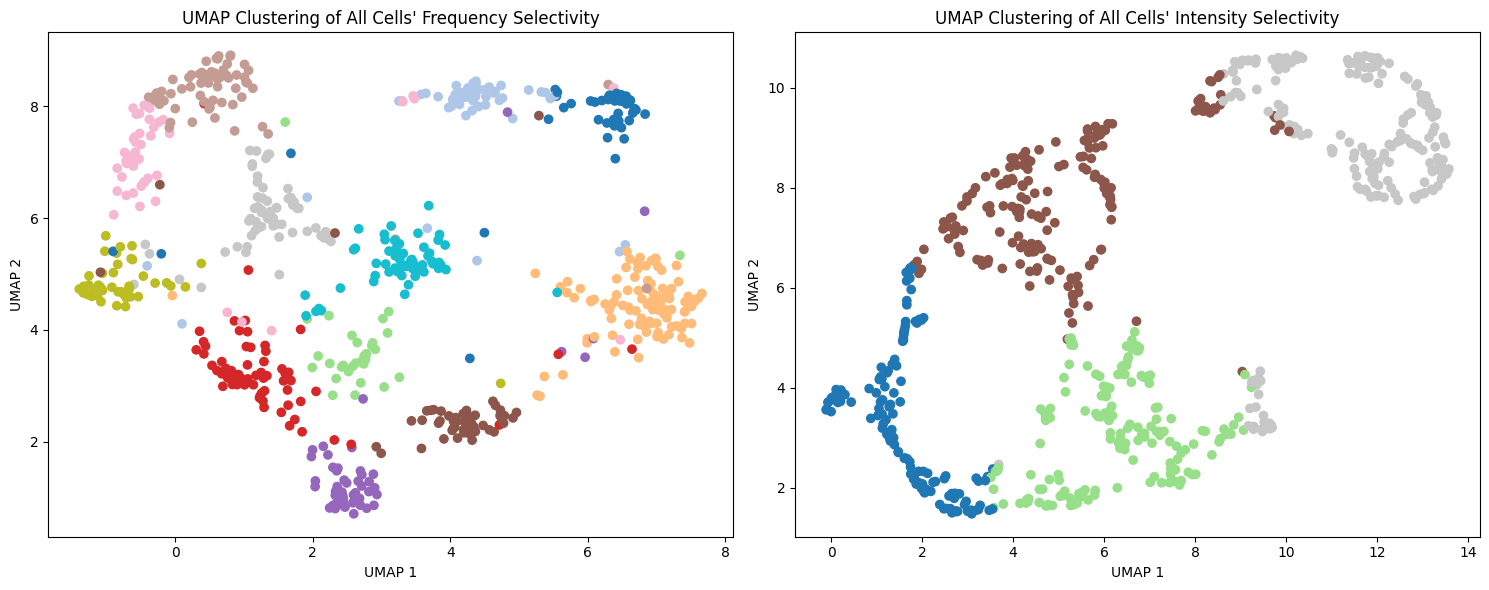

In [35]:
# fig, ax = plt.subplots(ncols=2)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})

plt.subplot(1,2,1)
plt.scatter(embedded_frequency[:,0],embedded_frequency[:,1],color=plt.cm.tab20(colours_frequency))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Clustering of All Cells' Frequency Selectivity")

plt.subplot(1,2,2)
plt.scatter(embedded_intensity[:,0],embedded_intensity[:,1],color=plt.cm.tab20(colours_intensity))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Clustering of All Cells' Intensity Selectivity")

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Cells')

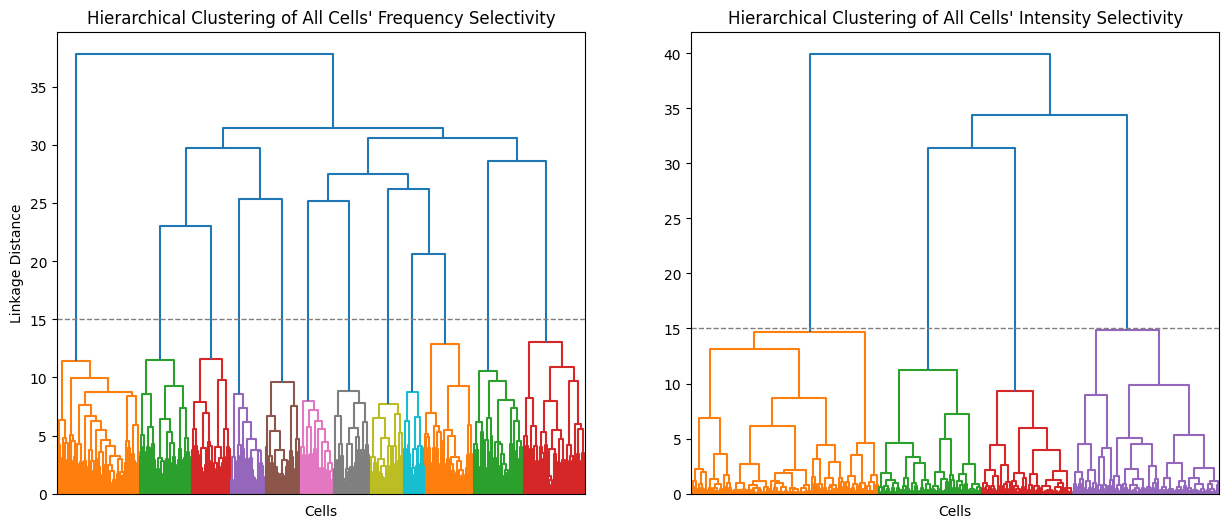

In [36]:
# HEIRARCHICAL CLUSTERING OF NEURONAL FREQUENCY SELECTIVITY, ALL CELLS. 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})

plt.subplot(1,2,1)
z = linkage(freq_norm,method='ward',optimal_ordering=False)
dend = dendrogram(z,no_labels=True,color_threshold=15)
plt.axhline(y=15, c='grey', lw=1, linestyle='dashed')
plt.title("Hierarchical Clustering of All Cells' Frequency Selectivity")
plt.xlabel("Cells")
plt.ylabel("Linkage Distance")

plt.subplot(1,2,2)
z = linkage(inte_norm,method='ward',optimal_ordering=True)
dend = dendrogram(z,no_labels=True,color_threshold=15)
plt.axhline(y=15, c='grey', lw=1, linestyle='dashed')
plt.title("Hierarchical Clustering of All Cells' Intensity Selectivity")
plt.xlabel("Cells")




([<matplotlib.axis.XTick at 0x2bb41aaf940>,
 [Text(0, 0, '35'), Text(1, 0, '50'), Text(2, 0, '65'), Text(3, 0, '80')])

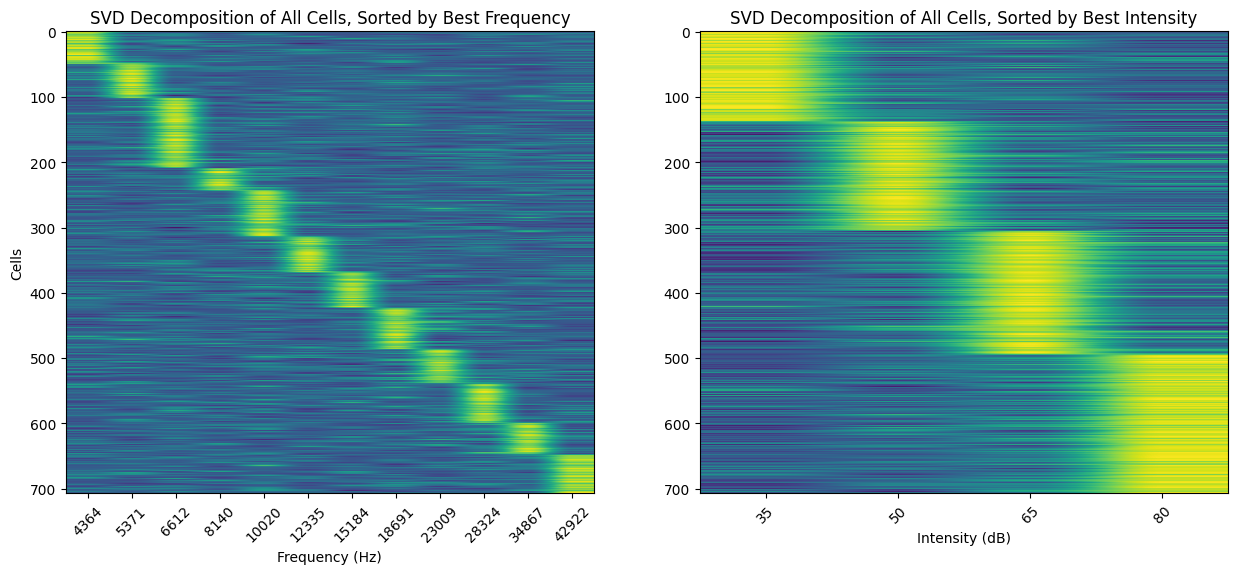

In [37]:
# HEIRARCHICAL CLUSTERING OF NEURONAL INTENSITY SELECTIVITY, ALL CELLS. 

idx_int = np.argsort(np.argmax(inte_norm,axis=1))
idx_freq = np.argsort(np.argmax(freq_norm,axis=1))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})

plt.subplot(1,2,1)
plt.imshow(freq_norm[idx_freq],aspect='auto')
plt.title("SVD Decomposition of All Cells, Sorted by Best Frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Cells")
plt.xticks(np.arange(len(nfreq)),nfreq,rotation=45)

plt.subplot(1,2,2)
plt.imshow(inte_norm[idx_int],aspect='auto')
plt.title("SVD Decomposition of All Cells, Sorted by Best Intensity")
plt.xlabel("Intensity (dB)")
plt.xticks(np.arange(len(nInt)),nInt,rotation=45)



